#Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import os
from pandas_datareader import data as pdr

#Load Dataset and NaN, Dupplicate Processing

In [ ]:
!apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [ ]:
def parse_volume(x: str):
    # chuyển "2.16M", "850K", "1.2B" -> số cổ phiếu
    if pd.isna(x): return np.nan
    s = str(x).strip().replace(',', '')
    m = re.match(r'^([+-]?\d*\.?\d+)\s*([KMB]?)$', s, flags=re.I)
    if not m:
        # Trường hợp chỉ là số: "1234567"
        try: return float(s)
        except: return np.nan
    val, suf = float(m.group(1)), m.group(2).upper()
    if suf == 'K': val *= 1_000
    elif suf == 'M': val *= 1_000_000
    elif suf == 'B': val *= 1_000_000_000
    return val

In [ ]:
def clean_vn_price_csv(path):
    # đọc thẳng, để pandas đoán delimiter
    df = pd.read_csv(path)
    # chuẩn hoá tên cột (strip, lower, bỏ dấu)
    colmap = {
        'Ngày':'date',
        'Ngày':'date',
        'Lần cuối':'close',
        'Lần cuối':'close',
        'Mở':'open',
        'Cao':'high',
        'Thấp':'low',
        'KL':'volume',
        'KLGD':'volume',
        '% Thay đổi':'pct_change',
        '% thay đổi':'pct_change',
        'Thay đổi %':'pct_change',
    }
    # map nếu có cột tương ứng
    df = df.rename(columns={c: colmap.get(c, c) for c in df.columns})

    # Chuẩn kiểu ngày dd/mm/yyyy
    df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')

    # Các cột giá: bỏ dấu phẩy hàng nghìn rồi float
    for c in ['open','high','low','close']:
        if c in df.columns:
            df[c] = (df[c].astype(str)
                           .str.replace(',', '', regex=False)
                           .str.replace(' ', '', regex=False))
            df[c] = pd.to_numeric(df[c], errors='coerce')

    # Khối lượng
    if 'volume' in df.columns:
        df['volume'] = df['volume'].apply(parse_volume)

    # % thay đổi -> float (ví dụ "0.51%")
    if 'pct_change' in df.columns:
        df['pct_change'] = (df['pct_change'].astype(str)
                                             .str.replace('%','', regex=False)
                                             .str.replace(',', '.', regex=False))
        df['pct_change'] = pd.to_numeric(df['pct_change'], errors='coerce') / 100.0

    # sắp xếp cũ -> mới và giữ cột chuẩn
    keep = [c for c in ['date','open','high','low','close','volume','pct_change'] if c in df.columns]
    df = df[keep].sort_values('date').dropna(subset=['date'])
    return df

In [ ]:
!unrar x stock_prices.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from stock_prices.rar

Creating    stock_prices                                              OK
Extracting  stock_prices/ACB.csv                                           3%  OK 
Extracting  stock_prices/BCM.csv                                           6%  OK 
Extracting  stock_prices/BID.csv                                          10%  OK 
Extracting  stock_prices/CTG.csv                                          13%  OK 
Extracting  stock_prices/DGC.csv                                          17%  OK 
Extracting  stock_prices/FPT.csv                                          21%  OK 
Extracting  stock_prices/GAS.csv                                          25%  OK 
Extracting  stock_prices/GVR.csv                                          28%  OK 
Extracting  stock_prices/HDB.csv                                          32%

In [ ]:
# fpt = clean_vn_price_csv('/content/FPT.csv')
# fpt.head(), fpt.info()

In [ ]:
folder = '/content/stock_prices'
frames = []

for fname in os.listdir(folder):
    if not fname.lower().endswith('.csv'):
        continue
    ticker = os.path.splitext(fname)[0].upper()
    df = clean_vn_price_csv(os.path.join(folder, fname))
    if len(df) == 0:
        print(f'⚠️ Bỏ qua {ticker}: rỗng sau khi làm sạch');
        continue
    df['ticker'] = ticker
    frames.append(df)

master = pd.concat(frames, ignore_index=True).sort_values(['date','ticker'])

# Lọc từ 2019-01-01
master = master[master['date'] >= pd.Timestamp('2018-12-31')]

# Lưu
# out_path = '/content/stock_prices_master.csv'
# master.to_csv(out_path, index=False)

In [ ]:
# master = master.drop('pct_change', axis=1)

In [ ]:
print(master.shape, master['ticker'].nunique())
master.head(50)

(49166, 8) 29


,date,open,high,low,close,volume,pct_change,ticker
37295,2019-01-02,11209.5,11209.5,10944.4,11058.0,2910000.0,-0.0135,ACB
28826,2019-01-02,24010.0,24010.0,21960.0,23424.0,32500.0,-0.0083,BCM
5081,2019-01-02,26327.8,26327.8,25600.7,25639.0,1010000.0,-0.0262,BID
32210,2019-01-02,14352.6,14501.8,14166.2,14166.2,3120000.0,-0.0155,CTG
8475,2019-01-02,12115.7,12115.7,11794.1,11794.1,816500.0,-0.0435,DGC
10166,2019-01-02,13566.1,13679.7,13355.2,13371.4,1220000.0,-0.0237,FPT
30513,2019-01-02,51930.1,52412.7,51930.1,52352.3,526380.0,0.0023,GAS
33907,2019-01-02,9258.0,9357.0,9258.0,9357.0,7900.0,-0.0777,GVR
18651,2019-01-02,11752.7,11752.7,10938.2,10938.2,1860000.0,-0.0693,HDB
3384,2019-01-02,8238.5,8385.2,8211.9,8211.9,15160000.0,-0.0048,HPG


In [ ]:
master['ticker'].unique()

array(['ACB', 'BCM', 'BID', 'CTG', 'DGC', 'FPT', 'GAS', 'GVR', 'HDB',
       'HPG', 'LPB', 'MBB', 'MSN', 'MWG', 'PLX', 'SAB', 'SHB', 'SSI',
       'STB', 'TCB', 'TPB', 'VCB', 'VHM', 'VIB', 'VIC', 'VJC', 'VNM',
       'VPB', 'VRE'], dtype=object)

In [ ]:
def map_field(ticker):
    if ticker in ['ACB','BID','CTG','HDB','LPB','MBB',
                  'SHB','SSB','STB','TCB','TPB','VCB','VIB','VPB']:
        return 'Bank'
    elif ticker in ['BCM','GVR','VHM','VRE']:
        return 'Real Estate'
    elif ticker in ['MSN','VIC']:
        return 'Conglomerate'
    elif ticker in ['GAS','HPG','PLX','DGC']:
      return 'Energy and Raw Materials'
    elif ticker in ['MWG','SAB','VNM']:
      return 'Retail & Consumer Goods'
    else:
      return 'Other Technology and Services'

In [ ]:
master['field'] = master['ticker'].apply(map_field)

In [ ]:
master.head()

,date,open,high,low,close,volume,pct_change,ticker,field
37295,2019-01-02,11209.5,11209.5,10944.4,11058.0,2910000.0,-0.0135,ACB,Bank
28826,2019-01-02,24010.0,24010.0,21960.0,23424.0,32500.0,-0.0083,BCM,Real Estate
5081,2019-01-02,26327.8,26327.8,25600.7,25639.0,1010000.0,-0.0262,BID,Bank
32210,2019-01-02,14352.6,14501.8,14166.2,14166.2,3120000.0,-0.0155,CTG,Bank
8475,2019-01-02,12115.7,12115.7,11794.1,11794.1,816500.0,-0.0435,DGC,Energy and Raw Materials


In [ ]:
master.tail()

,date,open,high,low,close,volume,pct_change,ticker,field
44077,2025-10-20,200000.0,204500.0,190000.0,194900.0,5670000.0,-0.0446,VIC,Conglomerate
22044,2025-10-20,174500.0,180000.0,165600.0,174500.0,3490000.0,-0.0029,VJC,Other Technology and Services
18650,2025-10-20,58900.0,59400.0,55000.0,55000.0,8740000.0,-0.0646,VNM,Retail & Consumer Goods
27128,2025-10-20,31550.0,31800.0,29750.0,29750.0,52630000.0,-0.0689,VPB,Bank
49165,2025-10-20,39500.0,41300.0,38150.0,38150.0,18980000.0,-0.0695,VRE,Real Estate


In [ ]:
master.isna().sum().sort_values(ascending=False)

,0
volume,1
date,0
open,0
low,0
high,0
close,0
pct_change,0
ticker,0
field,0


In [ ]:
# Lọc ra các hàng có ít nhất 1 NaN
rows_with_nan = master[master.isna().any(axis=1)]
len(rows_with_nan), rows_with_nan.head()

(1,
             date     open     high      low    close  volume  pct_change  \
 28894 2019-04-17  23500.0  23500.0  23500.0  22936.0     NaN         0.0   
 
       ticker        field  
 28894    BCM  Real Estate  )

In [ ]:
bad = master[master.isna().any(axis=1)]
print(bad)

            date     open     high      low    close  volume  pct_change  \
28894 2019-04-17  23500.0  23500.0  23500.0  22936.0     NaN         0.0   

      ticker        field  
28894    BCM  Real Estate  


In [ ]:
so_dong_lap = master.duplicated().sum()
print(so_dong_lap)

0


In [ ]:
master['date'] = pd.to_datetime(master['date'])

# Lọc BCM trong tháng 04/2019 (trừ ngày bị thiếu sẽ tự bị NaN)
mask_month = (
    (master['ticker'] == 'BCM') &
    (master['date'] >= '2019-04-01') & (master['date'] <= '2019-04-30')
)

mean_apr = master.loc[mask_month, 'volume'].mean(skipna=True)  # trung bình 29 ngày còn lại
master.loc[(master['ticker'] == 'BCM') & (master['date'] == '2019-04-17'), 'volume'] = mean_apr

In [ ]:
# Lọc ra các hàng có ít nhất 1 NaN
rows_with_nan = master[master.isna().any(axis=1)]
len(rows_with_nan), rows_with_nan.head()

(0,
 Empty DataFrame
 Columns: [date, open, high, low, close, volume, pct_change, ticker, field]
 Index: [])

#TÍNH TECHNICAL INDICATORS THEO TỪNG MÃ

In [ ]:
!pip install pandas_datareader pandas_ta

In [ ]:
import pandas_ta as ta
master['date'] = pd.to_datetime(master['date'])
master = master.sort_values(['ticker','date'])
master.head()

,date,open,high,low,close,volume,pct_change,ticker,field
37295,2019-01-02,11209.5,11209.5,10944.4,11058.0,2910000.0,-0.0135,ACB,Bank
37296,2019-01-03,9959.8,11020.1,9959.8,10641.4,5170000.0,-0.0377,ACB,Bank
37297,2019-01-04,10603.6,10792.9,10452.1,10717.2,7320000.0,0.0071,ACB,Bank
37298,2019-01-07,10944.4,10944.4,10792.9,10868.6,3450000.0,0.0141,ACB,Bank
37299,2019-01-08,11891.1,11891.1,10792.9,10792.9,2230000.0,-0.0070,ACB,Bank


In [ ]:
def add_ta_features(df):
    df = df.sort_values('date').copy()
    # RSI(14)
    df['RSI_14']  = ta.rsi(df['close'], length=14)
    # MA(10), MA(50), MA(200)
    df['MA_10']   = ta.sma(df['close'], length=10)
    df['MA_50']   = ta.sma(df['close'], length=50)
    df['MA_200']  = ta.sma(df['close'], length=200)
    # MACD(12,26,9)
    macd = ta.macd(df['close'], fast=12, slow=26, signal=9)
    df['MACD_12']        = macd['MACD_12_26_9']
    df['MACD_SIGNAL_12_26'] = macd['MACDs_12_26_9']
    df['MACD_HIST_12_26_9']   = macd['MACDh_12_26_9']
    # ADX(14)
    adx = ta.adx(df['high'], df['low'], df['close'], length=14)
    df['ADX_14'] = adx['ADX_14']
    # STOCH(9,6) (mặc định smooth_k=3)
    st = ta.stoch(df['high'], df['low'], df['close'], k=9, d=6, smooth_k=3)
    df['STOCH_K_9'] = st['STOCHk_9_6_3']
    df['STOCH_D_6'] = st['STOCHd_9_6_3']
    # STOCHRSI(14) – lấy %K
    srs = ta.stochrsi(df['close'], length=14)
    df['STOCHRSI_14'] = srs['STOCHRSIk_14_14_3_3']
    return df

In [ ]:
master_ta = master.groupby('ticker', group_keys=False).apply(add_ta_features)

/tmp/ipython-input-176958948.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  master_ta = master.groupby('ticker', group_keys=False).apply(add_ta_features)


In [ ]:
# Cắt “warm-up” theo từng mã: bắt đầu từ dòng đầu tiên mà TẤT CẢ TA != NaN
ta_cols = ['RSI_14','MA_10','MA_50','MA_200',
           'MACD_12','MACD_SIGNAL_12_26','MACD_HIST_12_26_9',
           'ADX_14','STOCH_K_9','STOCH_D_6','STOCHRSI_14']

In [ ]:
def cut_from_first_full(df):
    df = df.sort_values('date').copy()
    mask_full = df[ta_cols].notna().all(axis=1)
    if not mask_full.any():      # mã quá ngắn (IPO muộn)
        return df.iloc[0:0]
    first_idx = mask_full.idxmax()
    start_date = df.loc[first_idx, 'date']
    return df[df['date'] >= start_date]

In [ ]:
master_ta = master_ta.groupby('ticker', group_keys=False).apply(cut_from_first_full)

/tmp/ipython-input-1924092092.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  master_ta = master_ta.groupby('ticker', group_keys=False).apply(cut_from_first_full)


In [ ]:
# Lọc ra các hàng có ít nhất 1 NaN
rows_with_nan = master_ta[master_ta.isna().any(axis=1)]
len(rows_with_nan), rows_with_nan.head()

(0,
 Empty DataFrame
 Columns: [date, open, high, low, close, volume, pct_change, ticker, field, RSI_14, MA_10, MA_50, MA_200, MACD_12, MACD_SIGNAL_12_26, MACD_HIST_12_26_9, ADX_14, STOCH_K_9, STOCH_D_6, STOCHRSI_14]
 Index: [])

In [ ]:
so_dong_lap = master_ta.duplicated().sum()
print(so_dong_lap)

0


In [ ]:
master_ta.head()

,date,open,high,low,close,volume,pct_change,ticker,field,RSI_14,MA_10,MA_50,MA_200,MACD_12,MACD_SIGNAL_12_26,MACD_HIST_12_26_9,ADX_14,STOCH_K_9,STOCH_D_6,STOCHRSI_14
37494,2019-10-22,11520.0,11569.2,11470.8,11569.2,3370000.0,0.0043,ACB,Bank,49.766640,11835.07,11253.170,11235.0560,147.870007,183.621967,-35.751960,44.729019,29.908218,71.427546,14.882278
37495,2019-10-23,11569.2,11667.7,11569.2,11569.2,2000000.0,0.0000,ACB,Bank,49.766640,11825.22,11268.924,11237.6120,123.828038,171.663181,-47.835143,43.367878,12.812500,59.026177,4.659969
37496,2019-10-24,11618.5,11618.5,11520.0,11618.5,1870000.0,0.0043,ACB,Bank,51.688781,11805.53,11287.632,11242.4975,107.513356,158.833216,-51.319861,41.841424,17.942708,46.831945,9.504912
37497,2019-10-25,11618.5,11618.5,11520.0,11618.5,2250000.0,0.0000,ACB,Bank,51.688781,11785.84,11306.340,11247.0040,93.505974,145.767768,-52.261794,40.424002,20.510417,35.806655,12.019870
37498,2019-10-28,11618.5,11766.2,11618.5,11667.7,2210000.0,0.0042,ACB,Bank,53.737623,11746.46,11324.064,11250.9995,85.390720,133.692358,-48.301638,39.622732,25.640625,26.747512,17.215565


In [ ]:
master_ta.tail()

,date,open,high,low,close,volume,pct_change,ticker,field,RSI_14,MA_10,MA_50,MA_200,MACD_12,MACD_SIGNAL_12_26,MACD_HIST_12_26_9,ADX_14,STOCH_K_9,STOCH_D_6,STOCHRSI_14
49161,2025-10-14,44100.0,45200.0,42700.0,42750.0,32090000.0,-0.0058,VRE,Real Estate,84.572932,36805.0,31452.0,24127.50,2890.260074,1661.336287,1228.923787,33.911824,94.241376,92.257005,98.693382
49162,2025-10-15,42650.0,43050.0,41050.0,41900.0,19680000.0,-0.0199,VRE,Real Estate,79.276506,37680.0,31708.0,24251.75,3069.608848,1942.990799,1126.618049,34.923299,86.872146,92.543687,92.983977
49163,2025-10-16,42200.0,43500.0,41000.0,43400.0,17980000.0,0.0358,VRE,Real Estate,81.480624,38845.0,31957.0,24383.50,3294.801092,2213.352858,1081.448234,35.968741,81.830129,90.868652,88.388412
49164,2025-10-17,43500.0,43550.0,40800.0,41000.0,20870000.0,-0.0553,VRE,Real Estate,68.860914,39670.0,32175.0,24502.00,3242.233179,2419.128922,823.104257,36.795067,74.754053,88.458715,68.091155
49165,2025-10-20,39500.0,41300.0,38150.0,38150.0,18980000.0,-0.0695,VRE,Real Estate,57.476654,39985.0,32328.0,24607.00,2936.748539,2522.652845,414.095693,35.858007,61.021332,82.647892,40.467228


In [ ]:
#Lưu
out_path = '/content/stock_prices_master_ta.csv'
master_ta.to_csv(out_path, index=False)

#GDP from Fred, USD_VND and CPI from Investing.com

In [ ]:
!pip install -q fredapi

In [ ]:
from fredapi import Fred
import pandas as pd
from pandas_datareader import data as pdr

In [ ]:
dataset = pd.read_csv('/content/stock_prices_master_ta.csv')

In [ ]:
dataset['date'] = pd.to_datetime(dataset['date'])
dataset = dataset.sort_values(['ticker','date'])

In [ ]:
dataset.head()

,date,open,high,low,close,volume,pct_change,ticker,field,RSI_14,MA_10,MA_50,MA_200,MACD_12,MACD_SIGNAL_12_26,MACD_HIST_12_26_9,ADX_14,STOCH_K_9,STOCH_D_6,STOCHRSI_14
0,2019-10-22,11520.0,11569.2,11470.8,11569.2,3370000.0,0.0043,ACB,Bank,49.766640,11835.07,11253.170,11235.0560,147.870007,183.621967,-35.751960,44.729019,29.908218,71.427546,14.882278
1,2019-10-23,11569.2,11667.7,11569.2,11569.2,2000000.0,0.0000,ACB,Bank,49.766640,11825.22,11268.924,11237.6120,123.828038,171.663181,-47.835143,43.367878,12.812500,59.026177,4.659969
2,2019-10-24,11618.5,11618.5,11520.0,11618.5,1870000.0,0.0043,ACB,Bank,51.688781,11805.53,11287.632,11242.4975,107.513356,158.833216,-51.319861,41.841424,17.942708,46.831945,9.504912
3,2019-10-25,11618.5,11618.5,11520.0,11618.5,2250000.0,0.0000,ACB,Bank,51.688781,11785.84,11306.340,11247.0040,93.505974,145.767768,-52.261794,40.424002,20.510417,35.806655,12.019870
4,2019-10-28,11618.5,11766.2,11618.5,11667.7,2210000.0,0.0042,ACB,Bank,53.737623,11746.46,11324.064,11250.9995,85.390720,133.692358,-48.301638,39.622732,25.640625,26.747512,17.215565


In [ ]:
dataset.describe()

,date,open,high,low,close,volume,pct_change,RSI_14,MA_10,MA_50,MA_200,MACD_12,MACD_SIGNAL_12_26,MACD_HIST_12_26_9,ADX_14,STOCH_K_9,STOCH_D_6,STOCHRSI_14
count,43395,43395.000000,43395.000000,43395.000000,43395.000000,4.339500e+04,43395.000000,43395.000000,43395.000000,43395.000000,43395.000000,43395.000000,43395.000000,43395.000000,43395.000000,43395.000000,43395.000000,43395.000000
mean,2022-10-20 13:50:50.978223104,43810.768137,44362.839730,43228.580657,43798.334866,8.636526e+06,0.000726,51.834335,43749.608848,43572.165583,43254.602526,62.761239,60.194957,2.566282,26.365988,51.747284,51.756668,50.672339
min,2019-10-22 00:00:00,2727.000000,2925.000000,2628.000000,2776.000000,1.000000e+02,-0.519500,6.067759,2984.600000,3389.400000,3445.825000,-21936.877699,-19140.750288,-10063.319321,5.928893,-0.000157,1.976187,0.000000
25%,2021-04-22 00:00:00,18050.000000,18300.000000,17799.400000,18041.550000,1.390000e+06,-0.009000,43.081907,18015.000000,17843.860000,16928.210750,-345.871151,-327.668248,-119.492626,18.014767,27.956485,31.807814,19.754587
50%,2022-10-19 00:00:00,32448.600000,32850.000000,32000.000000,32414.200000,3.740000e+06,0.000000,51.578747,32380.000000,32000.720000,30762.250000,68.498970,70.254773,5.908297,23.859426,52.848677,52.607725,50.833053
75%,2024-04-19 00:00:00,63900.000000,64522.500000,63277.000000,63805.350000,1.024500e+07,0.010200,60.582172,63872.185000,63935.160000,63644.675000,498.781055,482.743094,126.886038,32.614768,75.944522,72.070800,81.757205
max,2025-10-20 00:00:00,262000.000000,262500.000000,260500.000000,261000.000000,2.496800e+08,0.125700,95.992548,259900.000000,265045.980000,260647.995000,18404.370864,16076.947406,6550.863852,82.291206,100.000000,98.817433,100.000000
std,NaN,33986.440897,34367.045323,33557.018672,33969.494737,1.336828e+07,0.022363,13.188870,33967.730405,34124.294021,35161.684311,1413.532443,1323.402733,418.816744,11.062856,27.010169,23.597799,32.777777


In [ ]:
dataset.shape, dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43395 entries, 0 to 43394
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               43395 non-null  datetime64[ns]
 1   open               43395 non-null  float64       
 2   high               43395 non-null  float64       
 3   low                43395 non-null  float64       
 4   close              43395 non-null  float64       
 5   volume             43395 non-null  float64       
 6   pct_change         43395 non-null  float64       
 7   ticker             43395 non-null  object        
 8   field              43395 non-null  object        
 9   RSI_14             43395 non-null  float64       
 10  MA_10              43395 non-null  float64       
 11  MA_50              43395 non-null  float64       
 12  MA_200             43395 non-null  float64       
 13  MACD_12            43395 non-null  float64       
 14  MACD_S

((43395, 20), None)

##Lấy GDP từ FRED

In [ ]:
fred = Fred(api_key='897a0069c65eaa41302baae2af5af953')
OBS_START = '2018-01-01'   # cần lùi 1 năm/tháng để có giá trị cho 2020-01
OBS_END   = '2025-10-20'

In [ ]:
# --- GDP cho Việt Nam ---
SERIES_GDP = 'MKTGDPVNA646NWDB'      # GDP current US$
gdp_ser = fred.get_series(SERIES_GDP, observation_start=OBS_START, observation_end=OBS_END)
gdp = gdp_ser.to_frame('GDP_val')
gdp.index = pd.to_datetime(gdp.index)

# Lấy 1 giá trị/năm (cuối năm), rồi shift sang NĂM SAU
gdp_annual = gdp.resample('Y').last().copy()
gdp_annual['year_for_use'] = gdp_annual.index.year + 1   # năm mà ta SẼ sử dụng giá trị của năm trước
gdp_map = dict(zip(gdp_annual['year_for_use'], gdp_annual['GDP_val']))
# => ví dụ GDP_2019 được map cho year_for_use=2020

/tmp/ipython-input-4211803519.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  gdp_annual = gdp.resample('Y').last().copy()


In [ ]:
#Áp các mapping vào dataset (không hề nhìn trước)
dataset['YEAR'] = dataset['date'].dt.year
dataset['GDP × 10^9 (USD)'] = dataset['YEAR'].map(gdp_map)     # GDP của NĂM TRƯỚC
dataset['GDP × 10^9 (USD)'] = (dataset['GDP × 10^9 (USD)'] / 1e9).round(2)

In [ ]:
#Giới hạn khung thời gian
dataset = dataset[(dataset['date'] >= '2020-01-01') & (dataset['date'] <= '2025-10-20')]

In [ ]:
#Dọn cột tạm & lưu
dataset = dataset.drop(columns=['YEAR'])
# out_path = '/content/stock_prices_master_ta_with_GDP_CPI.csv'
# dataset.to_csv(out_path, index=False)
# print('Saved:', out_path)

In [ ]:
dataset.head()

,date,open,high,low,close,volume,pct_change,ticker,field,RSI_14,...,MA_50,MA_200,MACD_12,MACD_SIGNAL_12_26,MACD_HIST_12_26_9,ADX_14,STOCH_K_9,STOCH_D_6,STOCHRSI_14,GDP × 10^9 (USD)
51,2020-01-02,11224.6,11323.1,11175.4,11323.1,2360000.0,0.0088,ACB,Bank,50.370623,...,11560.370,11299.0160,-80.180196,-107.764083,27.583887,25.819285,72.218461,49.226332,84.562094,334.37
52,2020-01-03,11323.1,11421.5,11273.8,11323.1,2140000.0,0.0000,ACB,Bank,50.370623,...,11554.462,11298.0695,-66.727752,-99.556817,32.829065,24.032942,79.366845,55.047986,96.086247,334.37
53,2020-01-06,11323.1,11323.1,11076.9,11076.9,2610000.0,-0.0217,ACB,Bank,40.306248,...,11543.630,11295.7025,-75.067543,-94.658962,19.591419,23.561703,57.148385,58.245687,76.499477,334.37
54,2020-01-07,11076.9,11175.4,11076.9,11076.9,2130000.0,0.0000,ACB,Bank,40.306248,...,11531.814,11294.0930,-80.746097,-91.876389,11.130292,23.124125,23.815051,54.961906,52.998953,334.37
55,2020-01-08,11076.9,11076.9,10830.8,10880.0,4680000.0,-0.0178,ACB,Bank,34.004354,...,11516.060,11291.1200,-99.982045,-93.497520,-6.484525,23.870570,2.776367,48.479484,19.665620,334.37


In [ ]:
#Một dòng/ năm (đầu năm) – toàn bộ thị trường
check_year = (dataset.assign(year=dataset['date'].dt.year)
                      .query('year == year')
                      .sort_values('date')
                      .groupby('year', as_index=False)
                      .first()[['year','date','GDP × 10^9 (USD)']])
print(check_year)

   year       date  GDP × 10^9 (USD)
0  2020 2020-01-02            334.37
1  2021 2021-01-04            346.62
2  2022 2022-01-04            366.47
3  2023 2023-01-03            413.45
4  2024 2024-01-02            433.86
5  2025 2025-01-02            476.39


##Web Scrapping for CPI from Investing.com

In [ ]:
# CÀI MÔI TRƯỜNG ỔN ĐỊNH CHO COLAB
!apt-get update -y >/dev/null
!apt-get install -y wget >/dev/null

# Cài Google Chrome stable (đồng bộ một nguồn)
!wget -q -O /tmp/chrome.deb https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
!dpkg -i /tmp/chrome.deb || apt-get -fy install -y  # tự xử lý phụ thuộc

# Selenium + WebDriver Manager (tự tải đúng chromedriver theo bản Chrome)
!pip -q install selenium==4.24.0 webdriver-manager==4.0.2 pandas==2.2.2

# Kiểm tra phiên bản
!google-chrome --version

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package google-chrome-stable.
(Reading database ... 125539 files and directories currently installed.)
Preparing to unpack /tmp/chrome.deb ...
Unpacking google-chrome-stable (142.0.7444.59-1) ...
dpkg: dependency problems prevent configuration of google-chrome-stable:
 google-chrome-stable depends on libvulkan1; however:
  Package libvulkan1 is not installed.

dpkg: error processing package google-chrome-stable (--install):
 dependency problems - leaving unconfigured
Processing triggers for mailcap (3.70+nmu1ubuntu1) ...
Processing triggers for man-db (2.10.2-1) ...
Errors were encountered while processing:
 google-chrome-stable
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Correcting dependencies... Done
The following

In [ ]:
import shutil, re, time
from datetime import datetime
import pandas as pd

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager

# Đặt binary là Google Chrome stable vừa cài
chrome_bin = shutil.which("google-chrome") or shutil.which("google-chrome-stable")

opts = Options()
if chrome_bin:
    opts.binary_location = chrome_bin
opts.add_argument("--headless=new")
opts.add_argument("--no-sandbox")
opts.add_argument("--disable-dev-shm-usage")
opts.add_argument("--window-size=1920,1080")
opts.add_argument("--lang=vi-VN")
opts.add_argument("--user-agent=Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120 Safari/537.36")
# (tuỳ chọn) đôi khi hữu ích trên Colab
opts.add_argument("--disable-gpu")
opts.add_argument("--disable-software-rasterizer")

# WebDriverManager tự chọn đúng chromedriver khớp phiên bản Chrome
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=opts)

url = "https://vn.investing.com/economic-calendar/vietnamese-cpi-1851"
driver.get(url)
wait = WebDriverWait(driver, 25)

# Đóng popup cookie nếu có
for xp in [
    "//button[contains(.,'Chấp')]",
    "//button[contains(.,'đồng ý')]",
    "//button[contains(.,'Accept')]",
    "//button[contains(.,'I agree')]",
]:
    try:
        btn = WebDriverWait(driver, 3).until(EC.element_to_be_clickable((By.XPATH, xp)))
        btn.click(); break
    except Exception:
        pass

# Mở tab Lịch sử (nếu cần)
try:
    hist_anchor = driver.find_element(By.CSS_SELECTOR, 'a[name="history"]')
    driver.execute_script("arguments[0].click();", hist_anchor)
except Exception:
    pass

wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "#eventHistoryTable1851 tbody")))
print("> Bảng lịch sử đã sẵn sàng.")

> Bảng lịch sử đã sẵn sàng.


In [ ]:
# =======================
# 3) Click 'Hiển thị thêm' tới mốc 27/12/2019
# =======================
START_DATE = datetime.strptime("27/12/2019", "%d/%m/%Y")
END_DATE   = datetime.strptime("06/10/2025", "%d/%m/%Y")

def last_loaded_date():
    rows = driver.find_elements(By.CSS_SELECTOR, "#eventHistoryTable1851 tbody tr")
    if not rows:
        return None
    # hàng cuối là cũ nhất trong bảng
    last_td0 = rows[-1].find_elements(By.CSS_SELECTOR, "td")[0].text
    m = re.search(r"(\d{2}/\d{2}/\d{4})", last_td0)
    if not m:
        return None
    return datetime.strptime(m.group(1), "%d/%m/%Y")

clicks = 0
prev_rows = 0

while True:
    mind = last_loaded_date()
    rows_now = len(driver.find_elements(By.CSS_SELECTOR, "#eventHistoryTable1851 tbody tr"))
    if mind and mind <= START_DATE:
        break
    if rows_now == prev_rows and clicks > 0:
        # không load thêm nữa
        break
    prev_rows = rows_now

    try:
        btn = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "#showMoreHistory1851 a")))
        driver.execute_script("arguments[0].scrollIntoView({block: 'center'});", btn)
        driver.execute_script("arguments[0].click();", btn)
        clicks += 1
        # chờ số hàng tăng hoặc ngày cũ hơn xuất hiện
        WebDriverWait(driver, 20).until(
            lambda d: len(d.find_elements(By.CSS_SELECTOR, "#eventHistoryTable1851 tbody tr")) > rows_now
        )
        time.sleep(0.7)
    except Exception:
        # hết nút hoặc lỗi click -> dừng
        break

print(f"> Đã bấm 'Hiển thị thêm' {clicks} lần. Ngày cũ nhất hiện có: {last_loaded_date().strftime('%d/%m/%Y') if last_loaded_date() else 'N/A'}")

> Đã bấm 'Hiển thị thêm' 11 lần. Ngày cũ nhất hiện có: 29/11/2019


In [ ]:
# =======================
# 4) Trích 2 cột: Ngày Phát Hành & Thực tế
# =======================
rows = driver.find_elements(By.CSS_SELECTOR, "#eventHistoryTable1851 tbody tr")
data = []

for r in rows:
    tds = r.find_elements(By.CSS_SELECTOR, "td")
    if len(tds) < 3:
        continue

    # Cột 1: Ngày Phát Hành (vd: "06/10/2025 (Tháng 9)")
    date_raw = tds[0].text.strip()
    m = re.search(r"(\d{2}/\d{2}/\d{4})", date_raw)
    if not m:
        continue
    d = datetime.strptime(m.group(1), "%d/%m/%Y")

    # Lọc theo khoảng yêu cầu
    if not (START_DATE <= d <= END_DATE):
        continue

    # Cột 3: Thực tế (có thể rỗng hoặc “—”)
    actual_raw = tds[2].text.replace("\xa0", " ").strip()
    # giữ nguyên dạng "3.38%" (không ép float). Nếu muốn float %, bỏ comment 2 dòng dưới:
    # m2 = re.search(r"(-?\d+(?:[.,]\d+)?)\s*%", actual_raw)
    # actual_val = float(m2.group(1).replace(",", ".")) if m2 else None

    data.append({
        "NgayPhatHanh": d.strftime("%Y-%m-%d"),
        "ThucTe": actual_raw or None
    })

driver.quit()

df = pd.DataFrame(data).sort_values("NgayPhatHanh")
print(df.head(), "\n---\n", df.tail(), f"\n\nTổng số dòng: {len(df)}")

out_path = "/content/vn_cpi.csv"
df.to_csv(out_path, index=False, encoding="utf-8")
print(f"\n✅ Đã lưu: {out_path}")

   NgayPhatHanh ThucTe
69   2019-12-27  5.23%
68   2020-01-29  6.43%
67   2020-02-29  5.40%
66   2020-03-27  4.90%
65   2020-04-29  2.90% 
---
   NgayPhatHanh ThucTe
4   2025-06-06  3.24%
3   2025-07-05  3.57%
2   2025-08-06  3.19%
1   2025-09-06  3.24%
0   2025-10-06  3.38% 

Tổng số dòng: 70

✅ Đã lưu: /content/vn_cpi_investing_2019-12-27_to_2025-10-06.csv


Sau khi tải vn_cpi_investing_2019-12-27_to_2025-10-06.csv về thì nhóm có chỉnh lại thủ công dữ liệu của cột NgayPhatHanh từ ngày 29/07/2024

**Giải thích**:
- Bảng “Lịch sử” của Investing hiển thị theo ngày bài viết được đăng trên site, đôi khi lệch sang đầu tháng kế tiếp, nhưng trong ngoặc vẫn ghi “(Tháng X)” – tức kỳ tham chiếu của chỉ số CPI.

- Nếu giữ nguyên ngày đăng bài (ví dụ 06/09/2024 cho Tháng 8), khi ghép dữ liệu tài chính theo thời gian sẽ làm sai lệch tháng (CPI tháng 8 bị rơi vào tháng 9) → gây misalignment và tiềm ẩn look-ahead bias khi huấn luyện mô hình.

**Quy ước để chỉnh sửa**:

- Lấy ngày 29 của hàng tháng, riêng tháng 2 là ngày 28

**Ví dụ**:
- 29/07/2024 (Tháng 7) -> 29/07/2024
- 06/09/2024 (Tháng 8) -> 29/08/2024
- ....
- 06/10/2025 (Tháng 9) -> 29/09/2025


###read cpi csv from web and processing

In [ ]:
import pandas as pd
cpi_reader = pd.read_csv('vn_cpi.csv', sep=';', dtype=str, encoding='utf-8')
cpi_reader.head()

,NgayPhatHanh,ThucTe
0,27/12/2019,5.23%
1,29/01/2020,6.43%
2,29/02/2020,5.40%
3,27/03/2020,4.90%
4,29/04/2020,2.90%


In [ ]:
# Parse ngày dd/mm/yyyy  -> datetime
cpi_reader['NgayPhatHanh'] = pd.to_datetime(
    cpi_reader['NgayPhatHanh'].astype(str).str.strip(),
    format='%d/%m/%Y', errors='coerce'
)

In [ ]:
# Chuyển đổi sang dạng Period (Tháng)
cpi_reader['NgayPhatHanh'] = cpi_reader['NgayPhatHanh'].dt.to_period('M')

In [ ]:
cpi_reader.head()

,NgayPhatHanh,ThucTe
0,2019-12,5.23%
1,2020-01,6.43%
2,2020-02,5.40%
3,2020-03,4.90%
4,2020-04,2.90%


In [ ]:
cpi_reader['ThucTe'] = (
    cpi_reader['ThucTe'].astype(str)
      .str.replace('\u00a0',' ', regex=False)    # bỏ NBSP
      .str.extract(r'(-?\d+(?:[.,]\d+)?)')[0]    # lấy phần số
      .str.replace(',','.')                      # phẩy -> chấm
      .astype(float) / 100
)

print(cpi_reader[['NgayPhatHanh','ThucTe']])

   NgayPhatHanh  ThucTe
0       2019-12  0.0523
1       2020-01  0.0643
2       2020-02  0.0540
3       2020-03  0.0490
4       2020-04  0.0290
..          ...     ...
65      2025-05  0.0324
66      2025-06  0.0357
67      2025-07  0.0319
68      2025-08  0.0324
69      2025-09  0.0338

[70 rows x 2 columns]


In [ ]:
#Bảo đảm kiểu ngày
dataset['date'] = pd.to_datetime(dataset['date'])

# Nếu cột NgayPhatHanh đang là Period[M], đổi về Timestamp (đầu tháng)
if pd.api.types.is_period_dtype(cpi_reader['NgayPhatHanh']):
    cpi_reader['NgayPhatHanh'] = cpi_reader['NgayPhatHanh'].dt.to_timestamp(how='start')

# 1) Tạo khóa tháng cho dataset
dataset['month_key'] = dataset['date'].dt.to_period('M')

# 2) Mapping CPI theo luật: CPI tháng M → gán cho các mẫu thuộc THÁNG M+1
cpi_map = cpi_reader[['NgayPhatHanh', 'ThucTe']].copy()     # ThucTe đã là ratio 0..1
cpi_map['month_key'] = (cpi_map['NgayPhatHanh'] + pd.offsets.MonthBegin(1)).dt.to_period('M')
cpi_map = (cpi_map
           .drop_duplicates('month_key', keep='last')       # phòng trùng tháng
           [['month_key','ThucTe']].rename(columns={'ThucTe':'CPI'}))

# 3) Merge vào dataset
dataset = dataset.merge(cpi_map, on='month_key', how='left').drop(columns='month_key')

/tmp/ipython-input-787033293.py:5: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(cpi_reader['NgayPhatHanh']):


In [ ]:
# Kiểm tra: tháng 2025-10 phải nhận CPI của 2025-09
print(dataset.loc[dataset['date'].dt.to_period('M')=='2025-10', ['date','CPI']])

            date     CPI
1428  2025-10-01  0.0338
1429  2025-10-02  0.0338
1430  2025-10-03  0.0338
1431  2025-10-06  0.0338
1432  2025-10-07  0.0338
...          ...     ...
41912 2025-10-14  0.0338
41913 2025-10-15  0.0338
41914 2025-10-16  0.0338
41915 2025-10-17  0.0338
41916 2025-10-20  0.0338

[406 rows x 2 columns]


In [ ]:
dataset.head()

,date,open,high,low,close,volume,pct_change,ticker,field,RSI_14,...,MA_200,MACD_12,MACD_SIGNAL_12_26,MACD_HIST_12_26_9,ADX_14,STOCH_K_9,STOCH_D_6,STOCHRSI_14,GDP × 10^9 (USD),CPI
0,2020-01-02,11224.6,11323.1,11175.4,11323.1,2360000.0,0.0088,ACB,Bank,50.370623,...,11299.0160,-80.180196,-107.764083,27.583887,25.819285,72.218461,49.226332,84.562094,334.37,0.0523
1,2020-01-03,11323.1,11421.5,11273.8,11323.1,2140000.0,0.0000,ACB,Bank,50.370623,...,11298.0695,-66.727752,-99.556817,32.829065,24.032942,79.366845,55.047986,96.086247,334.37,0.0523
2,2020-01-06,11323.1,11323.1,11076.9,11076.9,2610000.0,-0.0217,ACB,Bank,40.306248,...,11295.7025,-75.067543,-94.658962,19.591419,23.561703,57.148385,58.245687,76.499477,334.37,0.0523
3,2020-01-07,11076.9,11175.4,11076.9,11076.9,2130000.0,0.0000,ACB,Bank,40.306248,...,11294.0930,-80.746097,-91.876389,11.130292,23.124125,23.815051,54.961906,52.998953,334.37,0.0523
4,2020-01-08,11076.9,11076.9,10830.8,10880.0,4680000.0,-0.0178,ACB,Bank,34.004354,...,11291.1200,-99.982045,-93.497520,-6.484525,23.870570,2.776367,48.479484,19.665620,334.37,0.0523


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41917 entries, 0 to 41916
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               41917 non-null  datetime64[ns]
 1   open               41917 non-null  float64       
 2   high               41917 non-null  float64       
 3   low                41917 non-null  float64       
 4   close              41917 non-null  float64       
 5   volume             41917 non-null  float64       
 6   pct_change         41917 non-null  float64       
 7   ticker             41917 non-null  object        
 8   field              41917 non-null  object        
 9   RSI_14             41917 non-null  float64       
 10  MA_10              41917 non-null  float64       
 11  MA_50              41917 non-null  float64       
 12  MA_200             41917 non-null  float64       
 13  MACD_12            41917 non-null  float64       
 14  MACD_S

In [ ]:
dataset.shape

(41917, 22)

##USD_VND

In [ ]:
usd_vnd = pd.read_csv(
    'USD_VND.csv',
    sep=';',                 # file dùng dấu ';'
    decimal='.',             # dấu thập phân là '.'
    thousands=',',           # dấu phân tách hàng nghìn là ','
    parse_dates=['date'],    # đổi cột date sang datetime
    dayfirst=True,           # định dạng dd/mm/yyyy trong file
    dtype={'USD_VND':'float64'}
)

print(usd_vnd.dtypes)

date       datetime64[ns]
USD_VND           float64
dtype: object


In [ ]:
usd_vnd

,date,USD_VND
0,2020-01-01,23171.0
1,2020-01-02,23168.0
2,2020-01-03,23171.0
3,2020-01-06,23176.0
4,2020-01-07,23175.0
...,...,...
1510,2025-10-14,26355.5
1511,2025-10-15,26340.0
1512,2025-10-16,26335.0
1513,2025-10-17,26342.0


In [ ]:
# Gán cột usd_vnd vào dataset theo ngày
dataset = dataset.merge(
    usd_vnd.rename(columns={'USD_VND': 'usd_vnd'})[['date', 'usd_vnd']],
    on='date',
    how='left'
)

In [ ]:
# Kiểm tra nhanh
print(dataset[['date', 'usd_vnd']].head())
print('Số ngày không khớp tỷ giá:', dataset['usd_vnd'].isna().sum())

        date  usd_vnd
0 2020-01-02  23168.0
1 2020-01-03  23171.0
2 2020-01-06  23176.0
3 2020-01-07  23175.0
4 2020-01-08  23175.0
Số ngày không khớp tỷ giá: 0


In [ ]:
dataset.head()

,date,open,high,low,close,volume,pct_change,ticker,field,RSI_14,...,MACD_12,MACD_SIGNAL_12_26,MACD_HIST_12_26_9,ADX_14,STOCH_K_9,STOCH_D_6,STOCHRSI_14,GDP × 10^9 (USD),CPI,usd_vnd
0,2020-01-02,11224.6,11323.1,11175.4,11323.1,2360000.0,0.0088,ACB,Bank,50.370623,...,-80.180196,-107.764083,27.583887,25.819285,72.218461,49.226332,84.562094,334.37,0.0523,23168.0
1,2020-01-03,11323.1,11421.5,11273.8,11323.1,2140000.0,0.0000,ACB,Bank,50.370623,...,-66.727752,-99.556817,32.829065,24.032942,79.366845,55.047986,96.086247,334.37,0.0523,23171.0
2,2020-01-06,11323.1,11323.1,11076.9,11076.9,2610000.0,-0.0217,ACB,Bank,40.306248,...,-75.067543,-94.658962,19.591419,23.561703,57.148385,58.245687,76.499477,334.37,0.0523,23176.0
3,2020-01-07,11076.9,11175.4,11076.9,11076.9,2130000.0,0.0000,ACB,Bank,40.306248,...,-80.746097,-91.876389,11.130292,23.124125,23.815051,54.961906,52.998953,334.37,0.0523,23175.0
4,2020-01-08,11076.9,11076.9,10830.8,10880.0,4680000.0,-0.0178,ACB,Bank,34.004354,...,-99.982045,-93.497520,-6.484525,23.870570,2.776367,48.479484,19.665620,334.37,0.0523,23175.0


#Check dataset

In [ ]:
# Kiểm tra xem có dòng nào trùng hoàn toàn không
duplicates = dataset[dataset.duplicated()]
print("Số dòng bị lặp:", len(duplicates))

# Nếu bạn muốn xem cụ thể các dòng lặp:
print(duplicates.head())

# Hoặc đếm theo khóa cụ thể (ví dụ: theo 'date' + 'ticker')
dup_by_key = dataset[dataset.duplicated(subset=['date', 'ticker'], keep=False)]
print(dup_by_key.sort_values(['date','ticker']))

Số dòng bị lặp: 0
Empty DataFrame
Columns: [date, open, high, low, close, volume, pct_change, ticker, field, RSI_14, MA_10, MA_50, MA_200, MACD_12, MACD_SIGNAL_12_26, MACD_HIST_12_26_9, ADX_14, STOCH_K_9, STOCH_D_6, STOCHRSI_14, GDP × 10^9 (USD), CPI, usd_vnd]
Index: []

[0 rows x 23 columns]
Empty DataFrame
Columns: [date, open, high, low, close, volume, pct_change, ticker, field, RSI_14, MA_10, MA_50, MA_200, MACD_12, MACD_SIGNAL_12_26, MACD_HIST_12_26_9, ADX_14, STOCH_K_9, STOCH_D_6, STOCHRSI_14, GDP × 10^9 (USD), CPI, usd_vnd]
Index: []

[0 rows x 23 columns]


In [ ]:
# Đếm tổng số giá trị NaN trong toàn DataFrame
print("Tổng số ô NaN:", dataset.isna().sum().sum())

# Đếm NaN theo từng cột
print("Số NaN theo cột:\n", dataset.isna().sum())

# Xem các dòng có ít nhất 1 giá trị NaN
nan_rows = dataset[dataset.isna().any(axis=1)]
print("Số dòng có NaN:", len(nan_rows))


Tổng số ô NaN: 0
Số NaN theo cột:
 date                 0
open                 0
high                 0
low                  0
close                0
volume               0
pct_change           0
ticker               0
field                0
RSI_14               0
MA_10                0
MA_50                0
MA_200               0
MACD_12              0
MACD_SIGNAL_12_26    0
MACD_HIST_12_26_9    0
ADX_14               0
STOCH_K_9            0
STOCH_D_6            0
STOCHRSI_14          0
GDP × 10^9 (USD)     0
CPI                  0
usd_vnd              0
dtype: int64
Số dòng có NaN: 0


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41917 entries, 0 to 41916
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               41917 non-null  datetime64[ns]
 1   open               41917 non-null  float64       
 2   high               41917 non-null  float64       
 3   low                41917 non-null  float64       
 4   close              41917 non-null  float64       
 5   volume             41917 non-null  float64       
 6   pct_change         41917 non-null  float64       
 7   ticker             41917 non-null  object        
 8   field              41917 non-null  object        
 9   RSI_14             41917 non-null  float64       
 10  MA_10              41917 non-null  float64       
 11  MA_50              41917 non-null  float64       
 12  MA_200             41917 non-null  float64       
 13  MACD_12            41917 non-null  float64       
 14  MACD_S

In [ ]:
dataset.shape

(41917, 23)

In [ ]:
out_path = '/content/dataset_stock_prices_VN30.csv'
dataset.to_csv(out_path, index=False)
print('Saved:', out_path)

Saved: /content/dataset_stock_prices_VN30.csv


#Correlation Matrix and Features Selection

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
dataset = pd.read_csv('/content/dataset_stock_prices_VN30.csv')
print(dataset.head())
print(dataset.columns)

         date     open     high      low    close     volume  pct_change  \
0  2020-01-02  11224.6  11323.1  11175.4  11323.1  2360000.0      0.0088   
1  2020-01-03  11323.1  11421.5  11273.8  11323.1  2140000.0      0.0000   
2  2020-01-06  11323.1  11323.1  11076.9  11076.9  2610000.0     -0.0217   
3  2020-01-07  11076.9  11175.4  11076.9  11076.9  2130000.0      0.0000   
4  2020-01-08  11076.9  11076.9  10830.8  10880.0  4680000.0     -0.0178   

  ticker field     RSI_14  ...    MACD_12  MACD_SIGNAL_12_26  \
0    ACB  Bank  50.370623  ... -80.180196        -107.764083   
1    ACB  Bank  50.370623  ... -66.727752         -99.556817   
2    ACB  Bank  40.306248  ... -75.067543         -94.658962   
3    ACB  Bank  40.306248  ... -80.746097         -91.876389   
4    ACB  Bank  34.004354  ... -99.982045         -93.497520   

   MACD_HIST_12_26_9     ADX_14  STOCH_K_9  STOCH_D_6  STOCHRSI_14  \
0          27.583887  25.819285  72.218461  49.226332    84.562094   
1          32.8290

In [ ]:
# Lấy danh sách các features số (bỏ qua date, ticker, field)
numeric_cols = dataset.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [col for col in numeric_cols if col != 'close']

# Dictionary lưu correlation của mỗi mã
correlations_by_ticker = {}

# Tính correlation với close cho TỪNG MÃ
for ticker in dataset['ticker'].unique():
    ticker_data = dataset[dataset['ticker'] == ticker]

    # Tính correlation của các features với close
    corr_with_close = ticker_data[numeric_cols].corr()['close']
    correlations_by_ticker[ticker] = corr_with_close.drop('close')

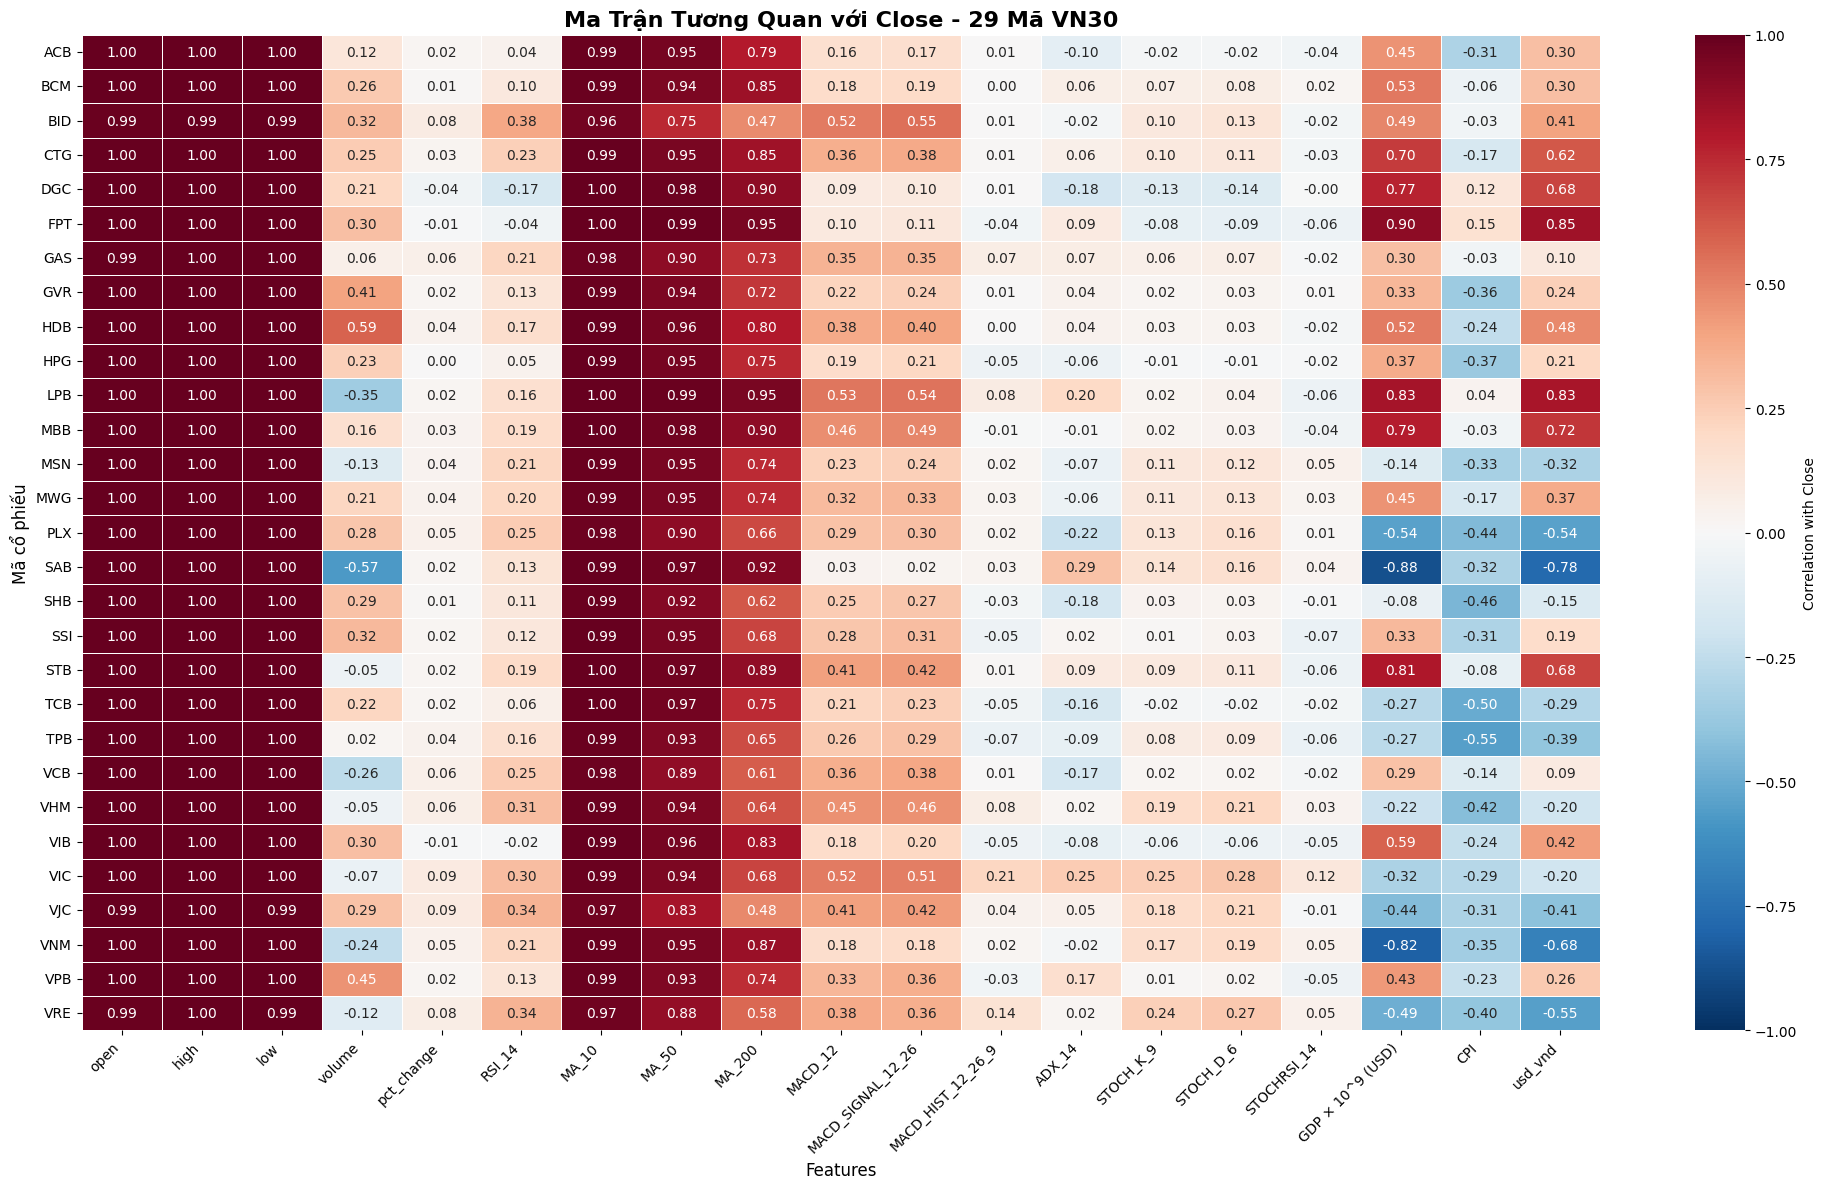

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#Heatmap tổng hợp - TẤT CẢ MÃ CÙNG LÚC
plt.figure(figsize=(20, 12))

# Chuyển dictionary thành DataFrame để vẽ
correlation_df = pd.DataFrame(correlations_by_ticker).T  # T để transpose
correlation_df = correlation_df.sort_index()  # Sắp xếp theo tên mã

# Vẽ heatmap
sns.heatmap(correlation_df,
            annot=True,           # Hiển thị giá trị
            fmt='.2f',            # Format 2 số thập phân
            cmap='RdBu_r',        # Red-Blue reversed
            center=0,             # Màu trắng ở giữa (0)
            vmin=-1, vmax=1,      # Range từ -1 đến 1
            cbar_kws={'label': 'Correlation with Close'},
            linewidths=0.5)

plt.title('Ma Trận Tương Quan với Close - 29 Mã VN30', fontsize=16, fontweight='bold')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Mã cổ phiếu', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##For all tickers

In [ ]:
# #TẠO correlation_df TỪ correlations_by_ticker
# correlation_df = pd.DataFrame(correlations_by_ticker).T

# # Tìm features có ÍT NHẤT 5 mã có |correlation| >= 0.3
# threshold = 0.3
# min_stocks = 5
# features_to_remove = []
# features_to_keep = []

# print("="*70)
# print(f"DANH SÁCH FEATURES KHÔNG ĐẠT YÊU CẦU (< {min_stocks} mã có |corr| >= {threshold}):")
# print("="*70)

# for feature in feature_cols:
#     count_high_corr = 0
#     max_corr = 0

#     for ticker in correlations_by_ticker:
#         corr_value = abs(correlations_by_ticker[ticker][feature])
#         max_corr = max(max_corr, corr_value)
#         if corr_value >= threshold:
#             count_high_corr += 1

#     if count_high_corr < min_stocks:
#         features_to_remove.append(feature)
#         print(f"'{feature}': chỉ {count_high_corr}/{len(correlations_by_ticker)} mã có |corr| >= {threshold} (Max = {max_corr:.3f})")
#     else:
#         features_to_keep.append(feature)

# print(f"\n📊 TÓM TẮT:")
# print(f"- Tổng features ban đầu: {len(feature_cols)}")
# print(f"- Features bị loại: {len(features_to_remove)}")
# print(f"- Features giữ lại: {len(features_to_keep)}")

# print(f"\n✅ FEATURES GIỮ LẠI ({len(features_to_keep)}):")
# for feat in features_to_keep:
#     count = sum(1 for ticker in correlations_by_ticker
#                 if abs(correlations_by_ticker[ticker][feat]) >= threshold)
#     print(f"  {feat:30s}: {count}/{len(correlations_by_ticker)} mã có |corr| >= {threshold}")

# # Vẽ heatmap CHỈ VỚI FEATURES GIỮ LẠI
# plt.figure(figsize=(16, 12))

# correlation_df_filtered = correlation_df[features_to_keep]

# sns.heatmap(correlation_df_filtered,
#             annot=True,
#             fmt='.2f',
#             cmap='RdBu_r',
#             center=0,
#             vmin=-1, vmax=1,
#             cbar_kws={'label': 'Correlation with Close'},
#             linewidths=0.5)

# plt.title(f'Ma Trận Tương Quan SAU KHI LỌC - Features có >= {min_stocks} mã với |corr| >= {threshold}',
#           fontsize=14, fontweight='bold')
# plt.xlabel('Features', fontsize=12)
# plt.ylabel('Mã cổ phiếu', fontsize=12)
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()

In [ ]:
# # Cập nhật dataframe - giữ lại features được chọn + các cột cần thiết
# columns_to_keep = ['date', 'ticker', 'field', 'close'] + features_to_keep

# # Tạo dataframe mới với các cột được chọn
# dataset_filtered = dataset[columns_to_keep].copy()

# # Kiểm tra kết quả
# print("="*70)
# print("THÔNG TIN DATASET SAU KHI LỌC:")
# print("="*70)
# print(f"Số dòng: {len(dataset_filtered)}")
# print(f"Số cột: {len(dataset_filtered.columns)}")
# print(f"\nDanh sách cột sau khi lọc:")
# print(dataset_filtered.columns.tolist())

# # Xem mẫu dữ liệu
# print("\nMẫu dữ liệu sau khi lọc:")
# print(dataset_filtered.head())
# print(f"   - Tổng số features (không kể date, ticker, field, close): {len(features_to_keep)}")
# print(f"   - Tổng số cột: {len(dataset_filtered.columns)}")
# print(f"   - Tổng số dòng: {len(dataset_filtered)}")

# # Thống kê chi tiết
# print("\n📊 THỐNG KÊ CHI TIẾT:")
# print(f"Dataset gốc: {len(dataset.columns)} cột x {len(dataset)} dòng")
# print(f"Dataset mới: {len(dataset_filtered.columns)} cột x {len(dataset_filtered)} dòng")
# print(f"Đã loại bỏ: {len(dataset.columns) - len(dataset_filtered.columns)} cột không đạt yêu cầu")

#Only Keeping Á Châu (ACB)

In [ ]:
# Copy dataset gốc
acb_df = dataset.copy()

# Chỉ giữ lại mã cổ phiếu ACB
acb_df = acb_df[acb_df['ticker'] == 'ACB']

print(acb_df.shape)
acb_df.head()

(1442, 23)


,date,open,high,low,close,volume,pct_change,ticker,field,RSI_14,...,MACD_12,MACD_SIGNAL_12_26,MACD_HIST_12_26_9,ADX_14,STOCH_K_9,STOCH_D_6,STOCHRSI_14,GDP × 10^9 (USD),CPI,usd_vnd
0,2020-01-02,11224.6,11323.1,11175.4,11323.1,2360000.0,0.0088,ACB,Bank,50.370623,...,-80.180196,-107.764083,27.583887,25.819285,72.218461,49.226332,84.562094,334.37,0.0523,23168.0
1,2020-01-03,11323.1,11421.5,11273.8,11323.1,2140000.0,0.0000,ACB,Bank,50.370623,...,-66.727752,-99.556817,32.829065,24.032942,79.366845,55.047986,96.086247,334.37,0.0523,23171.0
2,2020-01-06,11323.1,11323.1,11076.9,11076.9,2610000.0,-0.0217,ACB,Bank,40.306248,...,-75.067543,-94.658962,19.591419,23.561703,57.148385,58.245687,76.499477,334.37,0.0523,23176.0
3,2020-01-07,11076.9,11175.4,11076.9,11076.9,2130000.0,0.0000,ACB,Bank,40.306248,...,-80.746097,-91.876389,11.130292,23.124125,23.815051,54.961906,52.998953,334.37,0.0523,23175.0
4,2020-01-08,11076.9,11076.9,10830.8,10880.0,4680000.0,-0.0178,ACB,Bank,34.004354,...,-99.982045,-93.497520,-6.484525,23.870570,2.776367,48.479484,19.665620,334.37,0.0523,23175.0


##Keep All Features except pct_change

In [ ]:
acb_df = acb_df.drop(['pct_change'], axis = 1)
acb_df.head()

,date,open,high,low,close,volume,ticker,field,RSI_14,MA_10,...,MACD_12,MACD_SIGNAL_12_26,MACD_HIST_12_26_9,ADX_14,STOCH_K_9,STOCH_D_6,STOCHRSI_14,GDP × 10^9 (USD),CPI,usd_vnd
0,2020-01-02,11224.6,11323.1,11175.4,11323.1,2360000.0,ACB,Bank,50.370623,11195.08,...,-80.180196,-107.764083,27.583887,25.819285,72.218461,49.226332,84.562094,334.37,0.0523,23168.0
1,2020-01-03,11323.1,11421.5,11273.8,11323.1,2140000.0,ACB,Bank,50.370623,11219.70,...,-66.727752,-99.556817,32.829065,24.032942,79.366845,55.047986,96.086247,334.37,0.0523,23171.0
2,2020-01-06,11323.1,11323.1,11076.9,11076.9,2610000.0,ACB,Bank,40.306248,11209.85,...,-75.067543,-94.658962,19.591419,23.561703,57.148385,58.245687,76.499477,334.37,0.0523,23176.0
3,2020-01-07,11076.9,11175.4,11076.9,11076.9,2130000.0,ACB,Bank,40.306248,11195.08,...,-80.746097,-91.876389,11.130292,23.124125,23.815051,54.961906,52.998953,334.37,0.0523,23175.0
4,2020-01-08,11076.9,11076.9,10830.8,10880.0,4680000.0,ACB,Bank,34.004354,11165.54,...,-99.982045,-93.497520,-6.484525,23.870570,2.776367,48.479484,19.665620,334.37,0.0523,23175.0


In [ ]:
acb_df.rename(columns={
    'MACD_12': 'MACD',
    'MACD_SIGNAL_12_26': 'MACD_SIGNAL',
    'MACD_HIST_12_26_9': 'MACD_HIST',
    'STOCH_K_9': 'STOCH_K',
    'STOCH_D_6': 'STOCH_D'
}, inplace=True)

print("Columns renamed successfully.")

Columns renamed successfully.


In [ ]:
acb_df.head()

,date,open,high,low,close,volume,ticker,field,RSI_14,MA_10,...,MACD,MACD_SIGNAL,MACD_HIST,ADX_14,STOCH_K,STOCH_D,STOCHRSI_14,GDP × 10^9 (USD),CPI,usd_vnd
0,2020-01-02,11224.6,11323.1,11175.4,11323.1,2360000.0,ACB,Bank,50.370623,11195.08,...,-80.180196,-107.764083,27.583887,25.819285,72.218461,49.226332,84.562094,334.37,0.0523,23168.0
1,2020-01-03,11323.1,11421.5,11273.8,11323.1,2140000.0,ACB,Bank,50.370623,11219.70,...,-66.727752,-99.556817,32.829065,24.032942,79.366845,55.047986,96.086247,334.37,0.0523,23171.0
2,2020-01-06,11323.1,11323.1,11076.9,11076.9,2610000.0,ACB,Bank,40.306248,11209.85,...,-75.067543,-94.658962,19.591419,23.561703,57.148385,58.245687,76.499477,334.37,0.0523,23176.0
3,2020-01-07,11076.9,11175.4,11076.9,11076.9,2130000.0,ACB,Bank,40.306248,11195.08,...,-80.746097,-91.876389,11.130292,23.124125,23.815051,54.961906,52.998953,334.37,0.0523,23175.0
4,2020-01-08,11076.9,11076.9,10830.8,10880.0,4680000.0,ACB,Bank,34.004354,11165.54,...,-99.982045,-93.497520,-6.484525,23.870570,2.776367,48.479484,19.665620,334.37,0.0523,23175.0


In [ ]:
out_path_acb = '/content/dataset_ACB_fullFeatures.csv'
acb_df.to_csv(out_path_acb, index=False)
print('Saved:', out_path_acb)

Saved: /content/dataset_ACB_fullFeatures.csv


##Features Selection

In [ ]:
# 2) Chỉ lấy cột số để tính correlation
numeric_cols = acb_df.select_dtypes(include=[np.number]).columns.tolist()

# Đảm bảo có close trong numeric
if 'close' not in numeric_cols:
    raise ValueError("Cột 'close' không phải numeric hoặc không tồn tại trong dữ liệu!")

# 3) Correlation của numeric features với close
corr_with_close = acb_df[numeric_cols].corr()['close'].drop('close')

# 4) Lọc feature theo ngưỡng (ví dụ |corr| >= 0.299 ~ 0.3)
threshold = 0.299
selected_features = corr_with_close[abs(corr_with_close) >= threshold].index.tolist()

print(f"Selected numeric features (|corr| >= {threshold}):")
print(selected_features)

Selected numeric features (|corr| >= 0.299):
['open', 'high', 'low', 'MA_10', 'MA_50', 'MA_200', 'GDP × 10^9 (USD)', 'CPI', 'usd_vnd']


In [ ]:
# 5) DataFrame cuối: giữ date/ticker/field + close + các feature được chọn
meta_cols = [c for c in ['date', 'ticker', 'field'] if c in acb_df.columns]
keep_cols = meta_cols + ['close'] + selected_features

acb_selected_df = acb_df[keep_cols].copy()

print(acb_selected_df.shape)
display(acb_selected_df.head())

(1442, 13)


,date,ticker,field,close,open,high,low,MA_10,MA_50,MA_200,GDP × 10^9 (USD),CPI,usd_vnd
0,2020-01-02,ACB,Bank,11323.1,11224.6,11323.1,11175.4,11195.08,11560.370,11299.0160,334.37,0.0523,23168.0
1,2020-01-03,ACB,Bank,11323.1,11323.1,11421.5,11273.8,11219.70,11554.462,11298.0695,334.37,0.0523,23171.0
2,2020-01-06,ACB,Bank,11076.9,11323.1,11323.1,11076.9,11209.85,11543.630,11295.7025,334.37,0.0523,23176.0
3,2020-01-07,ACB,Bank,11076.9,11076.9,11175.4,11076.9,11195.08,11531.814,11294.0930,334.37,0.0523,23175.0
4,2020-01-08,ACB,Bank,10880.0,11076.9,11076.9,10830.8,11165.54,11516.060,11291.1200,334.37,0.0523,23175.0


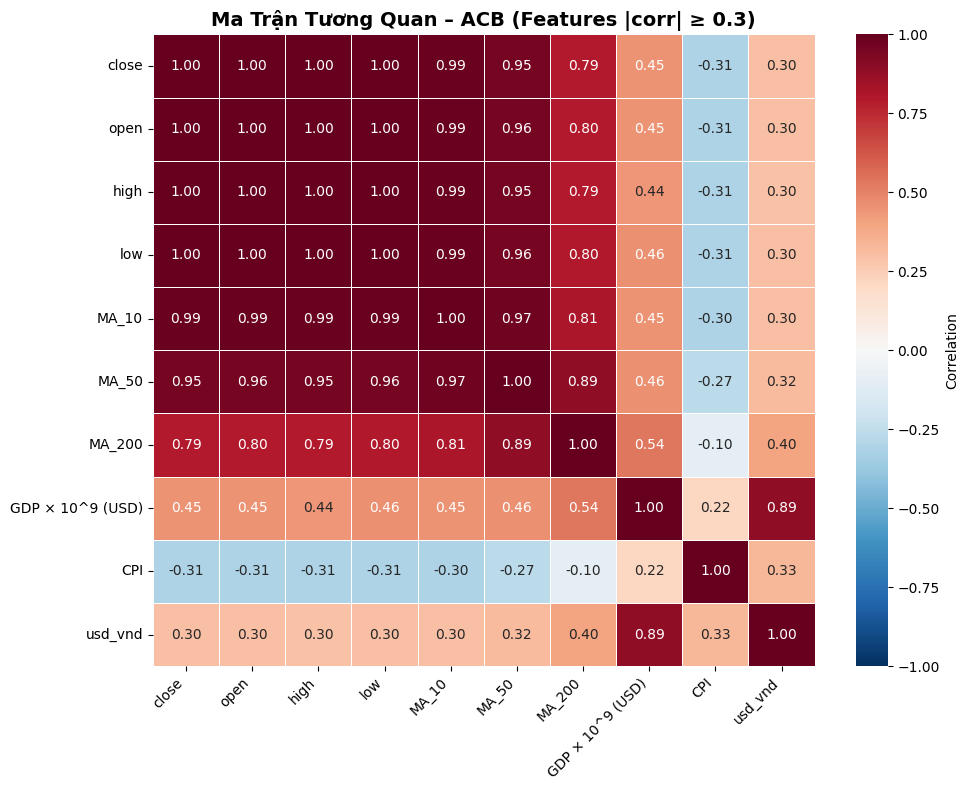

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Chỉ lấy cột số để tính corr (bỏ date/ticker/field tự động)
corr_df = acb_selected_df.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_df,
    annot=True,
    fmt='.2f',
    cmap='RdBu_r',
    center=0,
    vmin=-1, vmax=1,
    linewidths=0.5,
    cbar_kws={'label': 'Correlation'}
)

plt.title('Ma Trận Tương Quan – ACB (Features |corr| ≥ 0.3)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
out_path_acb = '/content/dataset_ACB.csv'
acb_selected_df.to_csv(out_path_acb, index=False)
print('Saved:', out_path_acb)

Saved: /content/dataset_ACB.csv


In [ ]:
print(acb_selected_df.shape)
acb_selected_df.head()

(1442, 13)


,date,ticker,field,close,open,high,low,MA_10,MA_50,MA_200,GDP × 10^9 (USD),CPI,usd_vnd
0,2020-01-02,ACB,Bank,11323.1,11224.6,11323.1,11175.4,11195.08,11560.370,11299.0160,334.37,0.0523,23168.0
1,2020-01-03,ACB,Bank,11323.1,11323.1,11421.5,11273.8,11219.70,11554.462,11298.0695,334.37,0.0523,23171.0
2,2020-01-06,ACB,Bank,11076.9,11323.1,11323.1,11076.9,11209.85,11543.630,11295.7025,334.37,0.0523,23176.0
3,2020-01-07,ACB,Bank,11076.9,11076.9,11175.4,11076.9,11195.08,11531.814,11294.0930,334.37,0.0523,23175.0
4,2020-01-08,ACB,Bank,10880.0,11076.9,11076.9,10830.8,11165.54,11516.060,11291.1200,334.37,0.0523,23175.0


In [ ]:
acb_selected_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1442 entries, 0 to 1441
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              1442 non-null   object 
 1   ticker            1442 non-null   object 
 2   field             1442 non-null   object 
 3   close             1442 non-null   float64
 4   open              1442 non-null   float64
 5   high              1442 non-null   float64
 6   low               1442 non-null   float64
 7   MA_10             1442 non-null   float64
 8   MA_50             1442 non-null   float64
 9   MA_200            1442 non-null   float64
 10  GDP × 10^9 (USD)  1442 non-null   float64
 11  CPI               1442 non-null   float64
 12  usd_vnd           1442 non-null   float64
dtypes: float64(10), object(3)
memory usage: 190.0+ KB


In [ ]:
acb_selected_df.describe()

,close,open,high,low,MA_10,MA_50,MA_200,GDP × 10^9 (USD),CPI,usd_vnd
count,1442.000000,1442.000000,1442.000000,1442.00000,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000
mean,20929.387309,20935.715950,21162.990499,20700.73190,20883.096165,20676.830982,20020.357444,392.342788,0.030952,24005.025659
std,4918.234911,4933.420553,4945.574090,4899.76047,4912.310816,4899.286107,4879.000111,48.950828,0.011521,1101.698427
min,8763.100000,7926.200000,9255.400000,7926.20000,9506.460000,10172.030000,11200.484500,334.370000,-0.009700,22625.000000
25%,18048.000000,18048.500000,18214.000000,17832.00000,17968.650000,17929.250000,17709.928750,346.620000,0.024700,23156.250000
50%,21134.000000,21134.000000,21350.000000,20921.00000,21078.300000,20786.190000,20815.685000,366.470000,0.031200,23500.000000
75%,25100.000000,25100.000000,25272.500000,24900.00000,25115.000000,25066.750000,24433.287500,433.860000,0.036300,24860.000000
max,30360.000000,30400.000000,30560.000000,29160.00000,29116.000000,28007.200000,26872.040000,476.390000,0.064300,26432.500000
